# Charged System Search based Feature Selection

import dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import DistanceMetric
from sklearn.naive_bayes import GaussianNB
import timeit

load dataset and split into input and outputs

In [2]:
train = pd.read_csv('resources/NSLKDD_2class_preprocessed_normalized/train_nslkdd_2class_preprocessed_normalized.csv')
test = pd.read_csv('resources/NSLKDD_2class_preprocessed_normalized/test_nslkdd_2class_preprocessed_normalized.csv')

In [3]:
train.shape, test.shape

((125973, 42), (22544, 42))

In [5]:
train_y = train['41']
train_x = train.drop(['41'], axis=1)
test_y = test['41']
test_x = test.drop(['41'], axis=1)

randomly initialise position for charged particles 

In [6]:
def init_particles(x):
    return np.random.randint(0, 2, size=(x,41))

initialise velocity for charged particles to 0

In [7]:
def init_velocity(x):
    return np.zeros((x, 41))

calculate fitness value (charge) for each charged particles

In [8]:
def fitness(accuracy):
    charge = (accuracy - min(accuracy)) / (max(accuracy) - min(accuracy))
    return charge

In [9]:
def cv_accuracy(particles):
    epsilon = 1e-6
    accuracy = []
    for particle in particles:
        X = train_x.iloc[:, np.nonzero(particle)[0]]
        clf = LogisticRegression(n_jobs=4, solver='lbfgs')
        cv = cross_val_score(clf, X, train_y, cv=3, scoring='accuracy')
        accuracy.append(cv.mean())
    return np.array(accuracy)

calculates distance between each CP

In [28]:
def distance(CP, charge, num_bestCP):
    dist = DistanceMetric.get_metric("hamming")
    good_CP = np.argsort(charge)[-num_bestCP:]
    pair_dist = dist.pairwise(CP)
    a = np.array
    d = []
    for i in good_CP:
        a = np.logical_and(CP[i], CP).astype(int)
        a = np.vstack((CP[good_CP[0]], a))
        denom = dist.pairwise(a)[0, 1:] + 1e-16
        num = pair_dist[i] + 1e-16
        d.append(num/denom)
    return np.array(d)

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [39]:
num_CP = 10
num_itr = 10
num_bestCP = 5
num_worstCP = 1
k_e = 0.1
CM_accuracy = 0
CP = init_particles(num_CP)
v = init_velocity(num_CP)

accuracy_matrix = []
features_matrix = []

for itr in range(num_itr):
    if num_bestCP == 0:
        break
    start = timeit.default_timer()
    accuracy = cv_accuracy(CP)
    max_accuracy = np.amax(accuracy)
    max_CP = CP[np.argmax(accuracy),:]
    accuracy_matrix.append(accuracy)
    features_matrix.append([np.count_nonzero(f) for f in CP])
    if max_accuracy > CM_accuracy:
        CM_accuracy = max_accuracy
        CM = np.copy(max_CP)
    print(max_accuracy, np.count_nonzero(max_CP))
    print(CM_accuracy, np.count_nonzero(CM))
    charge = fitness(accuracy)
    dist = distance(CP, charge, num_bestCP)
    best_charge = np.sort(charge)[-num_bestCP:]
    force_out = best_charge / np.square(dist.T)
    force_in = best_charge.T * dist.T
    np.place(force_out, force_out==np.inf, 0.0)
    np.place(force_in, force_in==np.inf, 0.0)
    i1 = np.zeros((num_CP,num_bestCP))
    i2 = np.zeros((num_CP,num_bestCP))
    i1[dist.T<=1] = 1
    i2[dist.T>1] = 1
    best_CP = CP[np.argsort(charge)[-num_bestCP:]]
    diff = []
    for cp in best_CP:
        diff.append(cp - CP)
    diff = np.array(diff)
    force = (i1*force_in) + (i2*force_out)
    x = []
    for i in range(num_bestCP):
        x.append(force.T[i].reshape(-1,1) * diff[i])
    x = np.array(x)
    acceleration = charge.reshape(-1,1) * np.sum(x, axis = 0)
    v = (np.random.random() * v) + acceleration
    CP[sigmoid(v)>0.5] = 1
    CP[sigmoid(v)<=0.5] = 0
    CP[np.argsort(charge)[:num_worstCP]] = init_particles(num_worstCP)
    if itr%2 == 0:
        num_bestCP-=1
    end = timeit.default_timer()
    print(i," execution time: ", end - start)

0.9525136448206544 23
0.9525136448206544 23
4  execution time:  84.07727108100153
0.9529026284035838 22
0.9529026284035838 22
3  execution time:  84.32054090299971
0.952481893308133 20
0.9529026284035838 22
3  execution time:  81.86356906299989
0.9548077989378506 17
0.9548077989378506 17
2  execution time:  85.22759854500146
0.9545220209568113 19
0.9548077989378506 17
2  execution time:  76.72583182600101
0.954514081613521 21
0.9548077989378506 17
1  execution time:  87.3701890909997
0.954514081613521 21
0.9548077989378506 17
1  execution time:  81.73273819400129
0.954514081613521 21
0.9548077989378506 17
0  execution time:  81.71086582399948
0.954514081613521 21
0.9548077989378506 17
0  execution time:  85.978559571


In [40]:
np.nonzero(CM)

(array([ 1,  2,  4,  7, 11, 12, 18, 19, 20, 24, 25, 26, 27, 28, 34, 37, 38]),)

In [41]:
high = np.nonzero(CM)[0]

In [47]:
log_reg = LogisticRegression(solver='lbfgs', max_iter=500)
log_reg.fit(train_x.iloc[:,high], train_y)
pred = log_reg.predict(test_x.iloc[:,high])
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(test_y, pred))
print(str(confusion_matrix(test_y, pred)))

0.7798527324343506
[[8200 4633]
 [ 330 9381]]


In [48]:
features_matrix = np.array(features_matrix)

In [49]:
accuracy_matrix[0], features_matrix[0]

(array([0.92805602, 0.93343018, 0.95151343, 0.93267607, 0.95251364,
        0.93486702, 0.89661279, 0.90397944, 0.94023326, 0.93239821]),
 array([18, 24, 26, 24, 23, 23, 16, 21, 22, 19]))

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

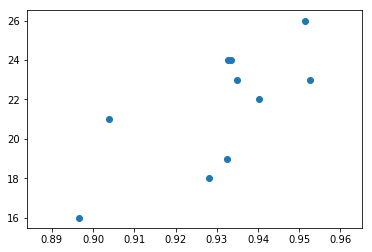

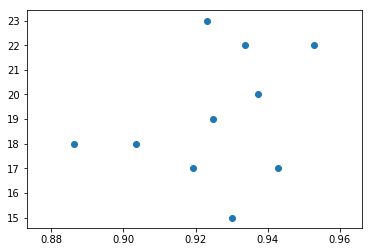

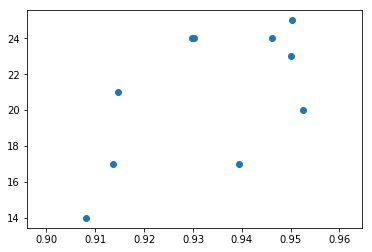

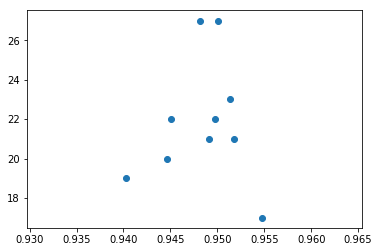

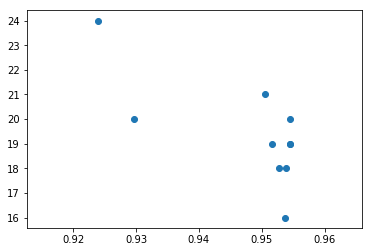

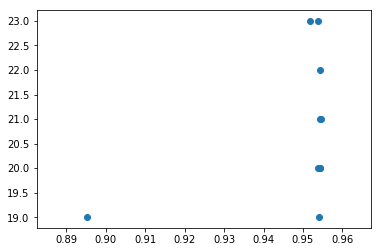

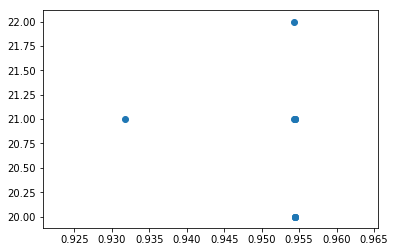

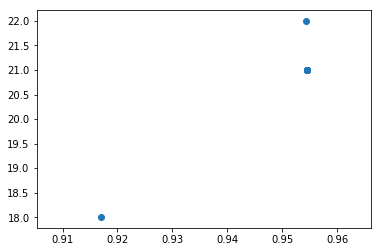

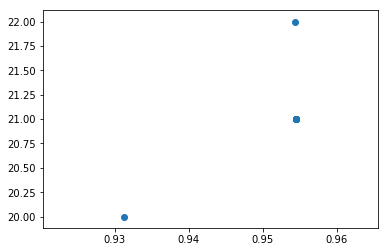

In [52]:
for i in range(num_itr):
    plt.figure()
    plt.scatter(accuracy_matrix[i], features_matrix[i])
    plt.show()